## Linearized Navier–Stokes Problem in Space–Time
# Why stabilization is nessecary?
In this notebook we solve the linearized Navier–Stokes problem using a full space–time finite element discretization. The governing equations are
$$
\partial_t u - \varepsilon \Delta u + (w \cdot \nabla)u - \nabla p = f
\quad \text{in } \Omega \times (0,T),
$$
$$
\nabla \cdot u = 0
\quad \text{in } \Omega \times (0,T),
$$
with spatial domain
$$
\Omega = [0,1] \times [0,1] \times [0,1].
$$

On the spatial boundary we impose Dirichlet data
$$
u(x,t) = u_D(x,t) \quad \text{for } x \in \partial\Omega,\; t \in [0,T],
$$
and we prescribe an initial condition
$$
u(x,0) = u_0(x) \quad \text{for } x \in \Omega.
$$

We employ a full space–time discretization and look for the velocity in
$$
u_h \in [P_1]^3,
$$
and the pressure in
$$
p_h \in P_1.
$$

As we will see, this equal-order pairing for velocity and pressure is in general not inf-sup stable, so an additional stabilization term for the pressure will be required.


In [13]:
from import_hack import *
from methodsnm.mesh_4d import *
from methodsnm.visualize import *
import math
import numpy as np
from numpy import exp
from methodsnm.vectorspace import *
from methodsnm.fes import *
from methodsnm.vectorspace import *
from netgen.csg import unit_cube
from ngsolve import Mesh,VOL,specialcf

In [14]:
def list_diff(a, b):
    """Entfernt alle Elemente aus Liste a, die in Liste b enthalten sind."""
    return [x for x in a if x not in b]

First we create a semistructured 4D mesh. We use an unstructured 3d mesh and with that we build a 4 dimensional prisma. As mentioned we are going to use P1 simplices (pentatopes). To enforce boundary condition later we mark the spacial boundary + the initial degree of freedoms. For that we use the top_bndry_vertices function wich gives us all the vertices lying on T=1

In [15]:
Ngmesh = Mesh(unit_cube.GenerateMesh(maxh=0.5))
mesh = UnstructuredHypertriangleMesh(4,Ngmesh)
V1 = P1_Hypertriangle_Space(mesh)
V2 = P1_Hypertriangle_Space(mesh)
V3 = P1_Hypertriangle_Space(mesh)
Q  = P1_Hypertriangle_Space(mesh)
fes = Productspace([V1,V2,V3,Q])

top = mesh.top_bndry_vertices
boundary = list_diff(mesh.vertices, top)

Now we construct an analytical example that solves the linearized Navier–Stokes system and then derive the corresponding right-hand side.

We choose the velocity field
$$
u_1(x,t) = \pi e^{-t}\,\sin(\pi x_0)\bigl(\cos(\pi x_1) - \cos(\pi x_2)\bigr),
$$
$$
u_2(x,t) = -\pi e^{-t}\,\cos(\pi x_0)\sin(\pi x_1),
$$
$$
u_3(x,t) = \pi e^{-t}\,\cos(\pi x_0)\sin(\pi x_2),
$$
and the pressure
$$
p(x,t) = 0.
$$

For a given constant convection field
$$
w = (w_1, w_2, w_3),
$$
the corresponding right-hand side components in
$$
\partial_t u - \varepsilon \Delta u + (w\cdot\nabla)u - \nabla p = f
$$
(with $\varepsilon = 1$ in this example) are

$$
f_1(x,t) =
\pi e^{-t}
\Bigl[
\sin(\pi x_0)\bigl(\cos(\pi x_1) - \cos(\pi x_2)\bigr)\,(-1 + 2\pi^2)
+ \pi\bigl(
w_1\cos(\pi x_0)\bigl(\cos(\pi x_1) - \cos(\pi x_2)\bigr)
- w_2\sin(\pi x_0)\sin(\pi x_1)
+ w_3\sin(\pi x_0)\sin(\pi x_2)
\bigr)
\Bigr],
$$

$$
f_2(x,t) =
\pi e^{-t}
\Bigl[
\cos(\pi x_0)\sin(\pi x_1)\,(1 - 2\pi^2)
+ \pi\bigl(
w_1\sin(\pi x_0)\sin(\pi x_1)
- w_2\cos(\pi x_0)\cos(\pi x_1)
\bigr)
\Bigr],
$$

$$
f_3(x,t) =
\pi e^{-t}
\Bigl[
\cos(\pi x_0)\sin(\pi x_2)\,(-1 + 2\pi^2)
+ \pi\bigl(
- w_1\sin(\pi x_0)\sin(\pi x_2)
+ w_3\cos(\pi x_0)\cos(\pi x_2)
\bigr)
\Bigr].
$$


In [16]:
from numpy import pi, sin, cos,exp
w1, w2, w3 = 1, 1, 1
w = ConstantVectorFunction([w1,w2,w3,1])

# u(x)
u1 = lambda x: pi*exp(-x[3])*sin(pi*x[0])*(cos(pi*x[1]) - cos(pi*x[2]))
u2 = lambda x: -pi*exp(-x[3])*cos(pi*x[0])*sin(pi*x[1])
u3 = lambda x:  pi*exp(-x[3])*cos(pi*x[0])*sin(pi*x[2])
p = lambda x: 0

# f(x), w1,w2,w3 vorher als Konstanten definieren
f1 = lambda x: (
    pi*exp(-x[3])*(
        sin(pi*x[0])*(cos(pi*x[1]) - cos(pi*x[2]))*(-1 + 2*pi*pi)
        + pi*( w1*cos(pi*x[0])*(cos(pi*x[1]) - cos(pi*x[2]))
               - w2*sin(pi*x[0])*sin(pi*x[1])
               + w3*sin(pi*x[0])*sin(pi*x[2]) )
    )
)

f2 = lambda x: (
    pi*exp(-x[3])*(
        cos(pi*x[0])*sin(pi*x[1])*(1 - 2*pi*pi)
        + pi*( w1*sin(pi*x[0])*sin(pi*x[1])
               - w2*cos(pi*x[0])*cos(pi*x[1]) )
    )
)

f3 = lambda x: (
    pi*exp(-x[3])*(
        cos(pi*x[0])*sin(pi*x[2])*(-1 + 2*pi*pi)
        + pi*( -w1*sin(pi*x[0])*sin(pi*x[2])
               + w3*cos(pi*x[0])*cos(pi*x[2]) )
    )
)
g = lambda x: 0

u_1 = GlobalFunction(u1, mesh)
u_2 = GlobalFunction(u2, mesh)
u_3 = GlobalFunction(u3, mesh)
p_ = GlobalFunction(p, mesh)
f_1 = GlobalFunction(f1, mesh = mesh)
f_2 = GlobalFunction(f2, mesh = mesh)
f_3 = GlobalFunction(f3, mesh = mesh)
g_ = GlobalFunction(g, mesh = mesh)


We assemble a 4×4 block system where each velocity component \(u_1,u_2,u_3\) receives its own diffusion and convection operators, which naturally couple only within the same component block because these terms act component-wise. The pressure–velocity coupling is added through divergence and gradient blocks, while a tiny mass term is placed in the pressure block to avoid a singular matrix. Finally, the right-hand side is assembled consistently for each component and for the divergence constraint.

This block structure corresponds to the weak formulation

$$
(u_t, v)_{\Omega} 
+ (\nabla u, \nabla v)_{\Omega} 
+ (w\cdot\nabla u, v)_{\Omega}
+ (\nabla\cdot u, q)_{\Omega}
+ (p, \nabla\cdot v)_{\Omega}
= (f, v)_{\Omega} + (g, q)_{\Omega}.
$$


In [17]:
from methodsnm.formint import *
from methodsnm.forms import *

c = ConstantFunction(0.0000001 ,mesh = mesh)
BF = BilinearVectorForm(fes)
for b in range(3):
    BF.add_block_integrator(b, b, LaplaceIntegral_without_time())
    BF.add_block_integrator(b, b, ConvectionIntegral(w))
for b in range(3):
    BF.add_block_integrator(3, b, DivUQIntegrator())
    BF.add_block_integrator(b, 3, DivVPIntegrator())
BF.add_block_integrator(3, 3, MassIntegral(c)) #to avoid singular matrix
BF.assemble()

LF = LinearVectorForm(fes)
LF.add_block_integrator(0, SourceIntegral(f_1))
LF.add_block_integrator(1, SourceIntegral(f_2))
LF.add_block_integrator(2, SourceIntegral(f_3))
LF.add_block_integrator(3, SourceIntegral(g_))
LF.assemble()

In [18]:
from methodsnm.solver import *

uh = FEVectorFunction(fes)
uh._set({0:(u1,boundary),1:(u2,boundary),2:(u3,boundary)})
res = LF.vector - BF.matrix@uh.vector
freedofs_global = fes.get_freedofs({0: boundary, 1: boundary, 2: boundary})
uh.vector += solve_on_freedofs(BF.matrix,res,freedofs_global)
uh1 , uh2 ,uh3 ,ph = uh.blocks()

In [19]:
from methodsnm.forms import compute_difference_L2
l2diff1 = compute_difference_L2(u_1, uh1, mesh, intorder = 5)
print("L2 difference:for velocity1" , l2diff1)
l2diff2 = compute_difference_L2(u_2, uh2, mesh, intorder = 5)
print("L2 difference:for velocity2 " , l2diff2)
l2diff3 = compute_difference_L2(u_3, uh3, mesh, intorder = 5)
print("L2 difference:for velocity3 " , l2diff3)
l2diff4 = compute_difference_L2(p_, ph, mesh, intorder = 5)
print("L2 difference:for pressure " , l2diff4)

L2 difference:for velocity1 0.5407313959699033
L2 difference:for velocity2  0.46251454335907793
L2 difference:for velocity3  0.3337208246612895
L2 difference:for pressure  21229846.993509527


As one can see, the $L^2$ -error for the pressure is very large, clearly indicating a problem with the method. Indeed, one can show that the $P_1$–$P_1$ velocity–pressure pairing is unstable because the discrete spaces do not satisfy the LBB (inf–sup) condition.

A standard remedy is to add a pressure stabilization term of the form

$$
c(p,q) = -h^2\,(\nabla p,\nabla q)_{\Omega}.
$$

This term penalizes spurious pressure oscillations, since for the exact (sufficiently smooth) solution $p$ we have $\nabla p \in L^2(\Omega)$ and the factor $h^2$ ensures that the stabilization vanishes in the limit $h \to 0 $.

For a detailed mathematical background and proofs of stability and convergence, we refer to the literature on stabilized finite element methods for incompressible flow, for example the standard references on SUPG/PSPG and pressure-stabilized formulations of the Stokes and Navier–Stokes equations.


In [20]:
delta = 10
BF = BilinearVectorForm(fes)
for b in range(3):
    BF.add_block_integrator(b, b, LaplaceIntegral_without_time())
    BF.add_block_integrator(b, b, ConvectionIntegral(w))
for b in range(3):
    BF.add_block_integrator(3, b, DivUQIntegrator())
    BF.add_block_integrator(b, 3, DivVPIntegrator())
BF.add_block_integrator(3,3,PressureStabilizationIntegral(delta))
BF.assemble()

In [21]:
from methodsnm.solver import *

uh = FEVectorFunction(fes)
uh._set({0:(u1,boundary),1:(u2,boundary),2:(u3,boundary)})
res = LF.vector - BF.matrix@uh.vector
freedofs_global = fes.get_freedofs({0: boundary, 1: boundary, 2: boundary})
uh.vector += solve_on_freedofs(BF.matrix,res,freedofs_global)
uh1 , uh2 ,uh3 ,ph = uh.blocks()

In [22]:
from methodsnm.forms import compute_difference_L2
l2diff1 = compute_difference_L2(u_1, uh1, mesh, intorder = 5)
print("L2 difference:for velocity1" , l2diff1)
l2diff2 = compute_difference_L2(u_2, uh2, mesh, intorder = 5)
print("L2 difference:for velocity2 " , l2diff2)
l2diff3 = compute_difference_L2(u_3, uh3, mesh, intorder = 5)
print("L2 difference:for velocity3 " , l2diff3)
l2diff4 = compute_difference_L2(p_, ph, mesh, intorder = 5)
print("L2 difference:for pressure " , l2diff4)

L2 difference:for velocity1 0.5306882552191444
L2 difference:for velocity2  0.4476060173831487
L2 difference:for velocity3  0.31849856544871735
L2 difference:for pressure  0.2584132501830139


As one can eazily see the L2 error is much lower. So we might assume that our method is stable. To verify a deeper mathematical analysis is required.

shape: (520, 520)
nnz  : 22090


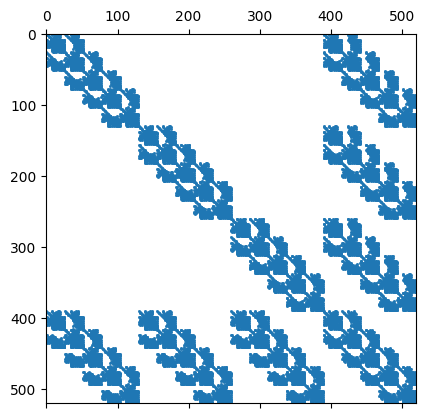

In [23]:
K = BF.matrix
rows, cols = K.nonzero()      
nnz = K.nnz                    

print("shape:", K.shape)
print("nnz  :", nnz)

#Sparsity-Plot
plt.figure()
plt.spy(K, markersize=1)
plt.show()

In the printed sparsity pattern one can clearly identify the block structure of the system matrix: the velocity block $A$, the coupling blocks $B$ and $B^\top$, and the (regularized) pressure block $-C$.

The block $A$ corresponds to the bilinear form  
$$
A(u,v) = (\partial_t u, v)_\Omega + (\nabla u,\nabla v)_\Omega + (w\cdot\nabla u, v)_\Omega,
$$
assembled component-wise for $u_1,u_2,u_3$.  
Since all these terms act **component-wise**, the sub-blocks associated with $u_1,u_2,u_3$ do not couple with each other, which is clearly visible in the sparsity pattern.

The block $B$ represents the discrete divergence operator,
$$
B(u,q) = (\nabla\cdot u, q)_\Omega,
$$
while $B^\top$ corresponds to the pressure gradient term
$$
B^\top(p,v) = (p, \nabla\cdot v)_\Omega.
$$

Finally, the block $C$ is the small pressure stabilization term
$$
C(p,q) = h^2(\nabla p,\nabla q)_\Omega,
$$
added  to stabilize the equal-order pairing.
